# Stage I

1) сгенерить waveform синуса,  с напр., 10k отсчетов (на один период) (1 Hz)

2) нарисовать его, нарисовать fft, и попробовать правильно подписать оси и деления шкал на них ;)

3) сымитировать оцифровку -- понизить чсило отсчетов например а) до 500, и до 25 — и повторить п.2, при этом увидеть какие искажения в спектре возникли

4) сымитировать "кривую" оцифровку -- при уменьшении частоты дескритезации брать отсчеты с разным смещением в лево и вправо,
(аналог физовых искажений, jitter), и снова посмотреть 2) на 5-10% периода

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftshift, rfft
from scipy import signal
from typing import Tuple, List, TypeVar
import random
import math
import seaborn as sn

%matplotlib inline

In [123]:
def sin_tick(sampling_rate: int, period: int = 1) -> Tuple[np.array, np.array]:
    x = np.linspace(0, 1 * int(period), sampling_rate, endpoint=True)
    y = np.sin(2 * np.pi * x)
    return x, y

def rand_sigh():
    return -1 if random.random() > 0.5 else 1.0

In [124]:
def sin_tick_rand_jitter(sampling_rate: int, periods_count: int, jitter_tick_max_percent: float = 0.0, jitter_magnitude_max_percent: float = 0.0) -> Tuple[np.array, np.array]:
    random.seed(1112220)
    x = []
    size = 0.
    jit_tick = (float(jitter_tick_max_percent) / 100.)
    jit_mag = (float(jitter_magnitude_max_percent) / 100.)
    lin_x = np.linspace(0, periods_count, sampling_rate, endpoint=True)
    for i, ix in enumerate(lin_x):
        if i in {0, sampling_rate}:
            x.append(float(ix))
            continue
        xf = float(ix)
        if size == 0.:
            size = abs(xf)
        xf = xf + size * jit_tick * rand_sigh()
        x.append(xf)
    random.seed(3312220)
    y = []
    for ix in x:
        yi = 1 * math.sin(2 * math.pi * ix)
        yi = yi + abs(yi) * jit_mag * rand_sigh()
        y.append(yi)
    assert jitter_tick_max_percent == 0. or jitter_magnitude_max_percent == 0.
    if jitter_tick_max_percent != 0.:
        return lin_x, np.array(y)
    return np.array(x), np.array(y)

# FFT

[scipy.fftpack](https://docs.scipy.org/doc/scipy/reference/fftpack.html)

`fft(x, n)` - Return discrete Fourier transform of real or complex sequence.

`fftshift(x)` - Shift the zero-frequency component to the center of the spectrum.

In [125]:
# The power spectrum is calculated as the square of
# the absolute value of the discrete Fourier transform
# https://www.kite.com/python/answers/how-to-plot-a-power-spectrum-in-python

def mk_signal_by_spectrum_magnitude(signal_fft: np.array, sampling_rate: int):
    t = np.linspace(0, 1, sampling_rate)
    r = np.fft.irfft(signal_fft, sampling_rate)

    plt.figure(figsize=(30, 4))
    plt.plot(t, r)
    plt.xlim((0, max(t)))
    plt.grid()
    plt.show()

def spectrum_magnitude(signal: np.array, sampling_rate: int, *, plot: bool) -> None:
    signal_fft = np.fft.rfft(signal, len(signal))
    spectrum = np.square(np.abs(signal_fft))

    freq = np.linspace(0, sampling_rate/2, len(signal_fft))

    df = pd.DataFrame({"spectrum": spectrum, "freq": freq})

    max_freq = df.iloc[df['spectrum'].idxmax()]['freq'] or 0.

    if plot:
        plt.grid()
        plt.title(f'magnitude spectrum (max_freq={max_freq:0.3f})')
        plt.xlabel("freq")
        plt.ylabel("level")
        plt.xlim([freq[0], min(max_freq * 10, freq[-1])])
        plt.plot(freq, spectrum)
    return spectrum, freq

def spectrum_phase(signal: np.array, sampling_rate: int, *, plot: bool) -> None:
    signal_fft = np.fft.rfft(signal, len(signal))
    freq = np.linspace(0, sampling_rate/2, len(signal_fft))
    phase_spectrum = np.angle(signal_fft)

    df = pd.DataFrame({"spectrum": np.square(np.abs(signal_fft)), "freq": freq})

    max_freq = df.iloc[df['spectrum'].idxmax()]['freq'] or 0.

    if plot:
        plt.grid()
        plt.title('phase spectrum')
        plt.xlabel("freq")
        plt.ylabel("level")
        plt.xlim([freq[0], min(max_freq * 10, freq[-1])])
        plt.plot(freq, phase_spectrum)
    return phase_spectrum, freq



sampling_rate=10000


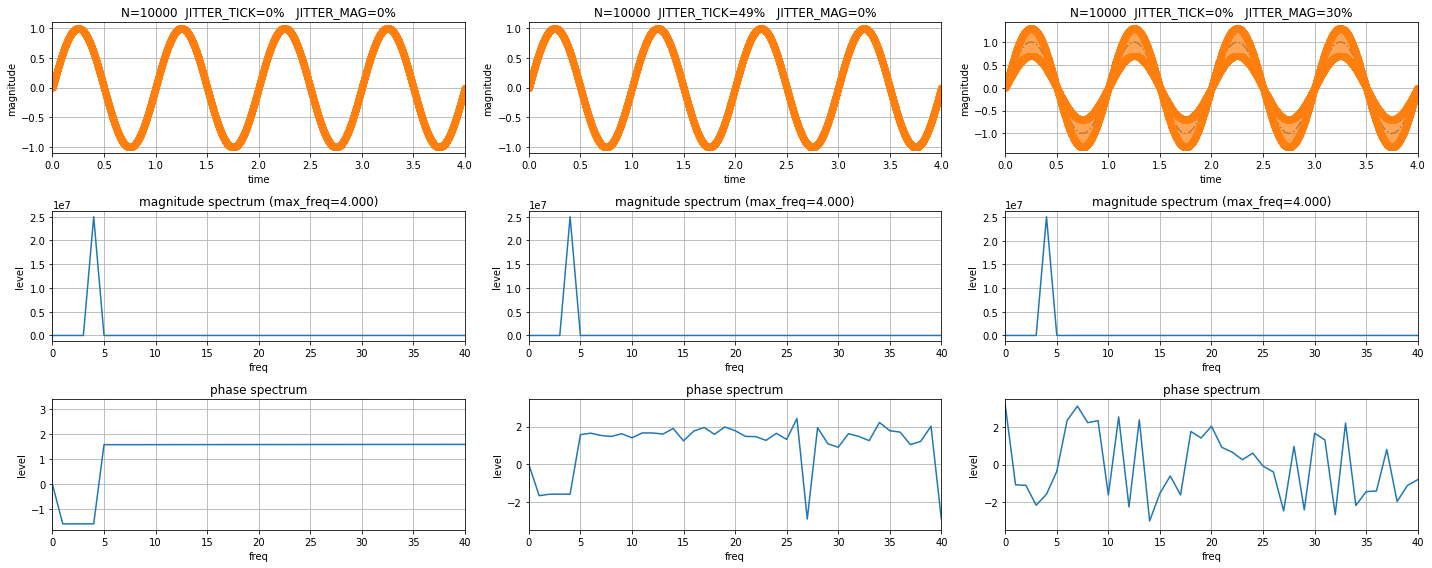



sampling_rate=5000


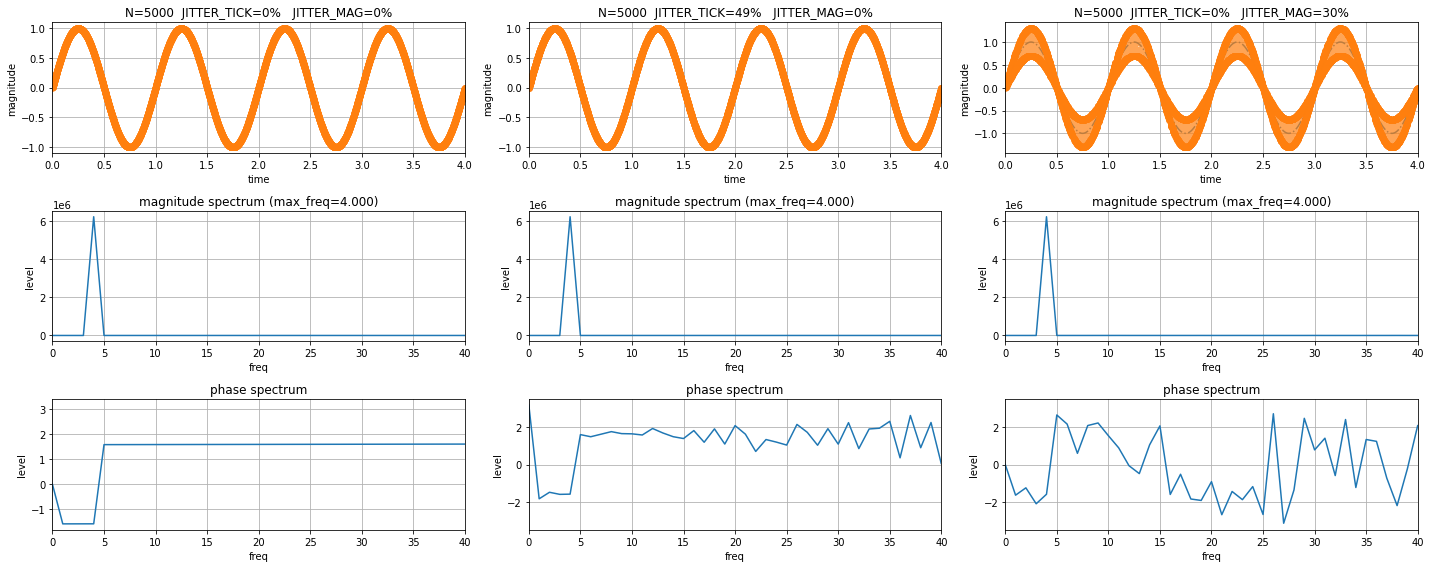



sampling_rate=500


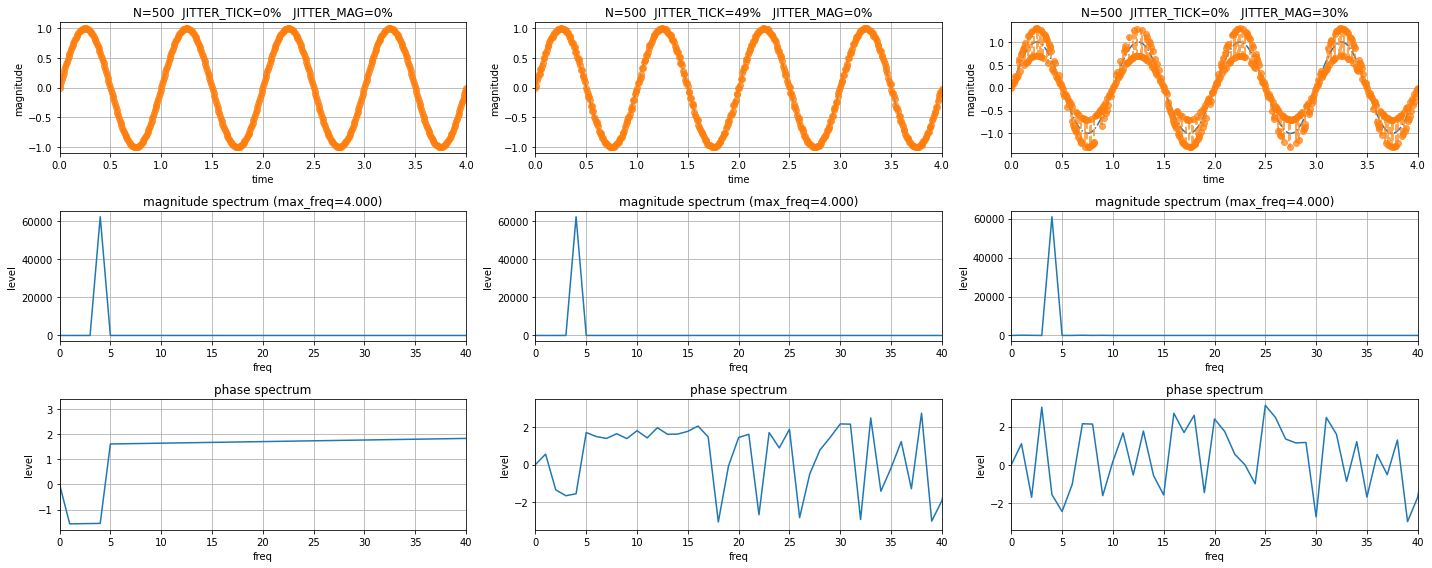



sampling_rate=100


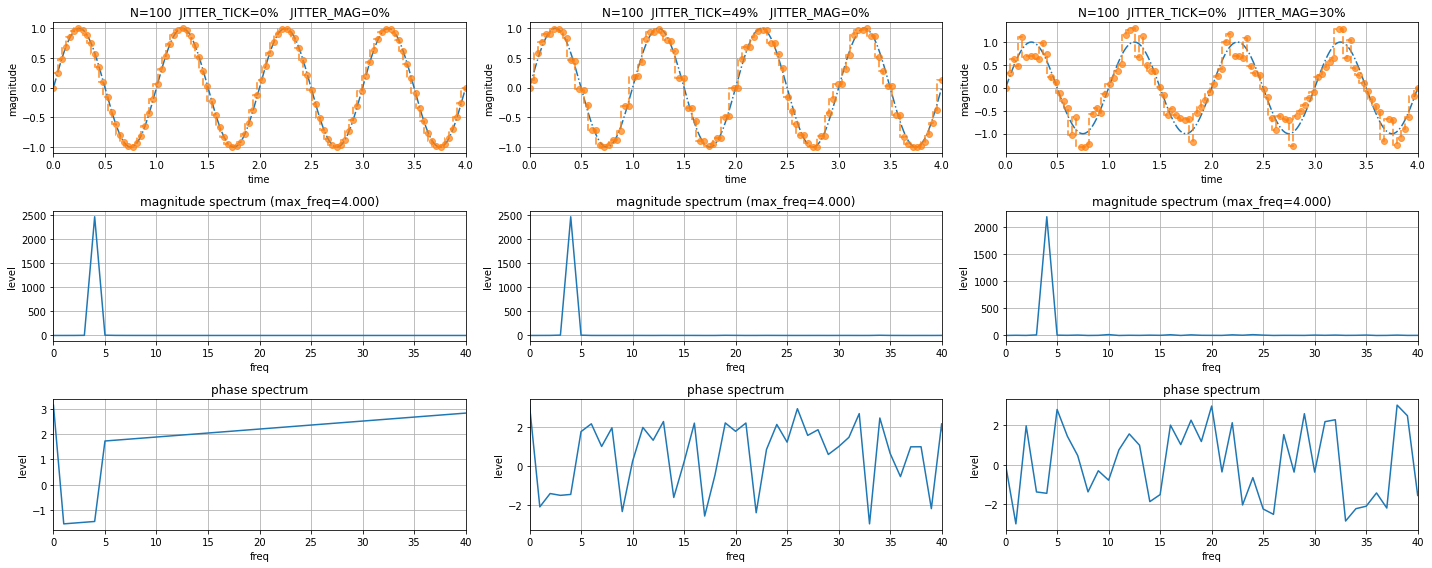



sampling_rate=25


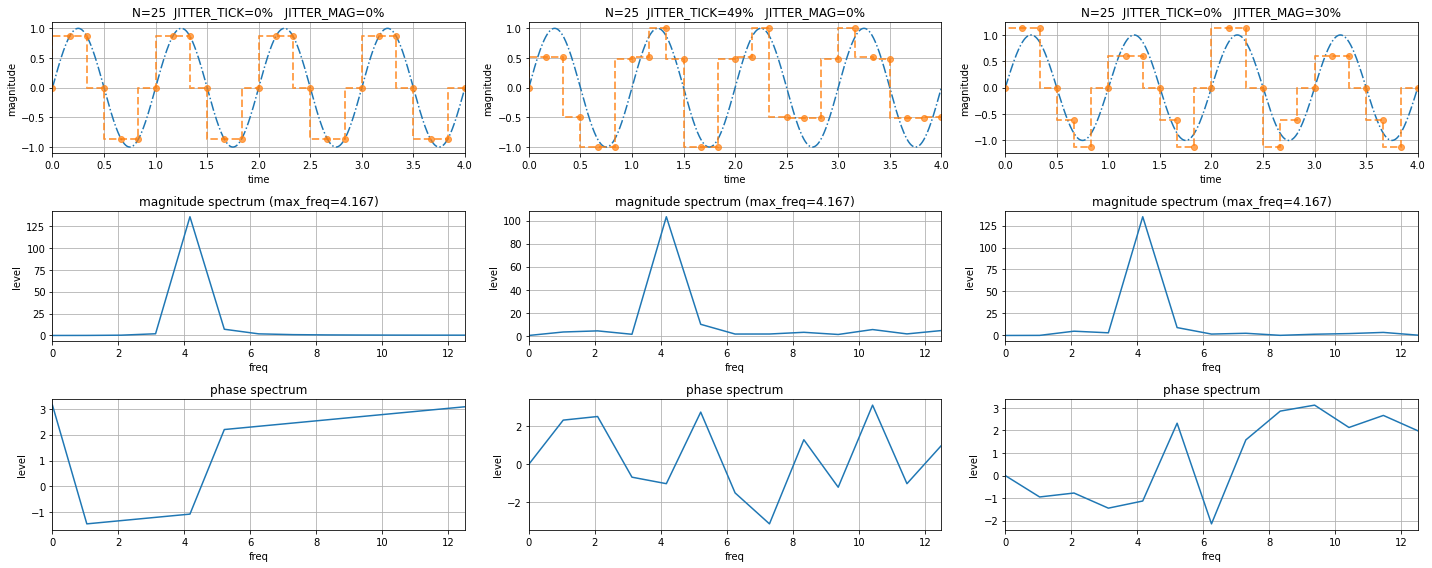



sampling_rate=10


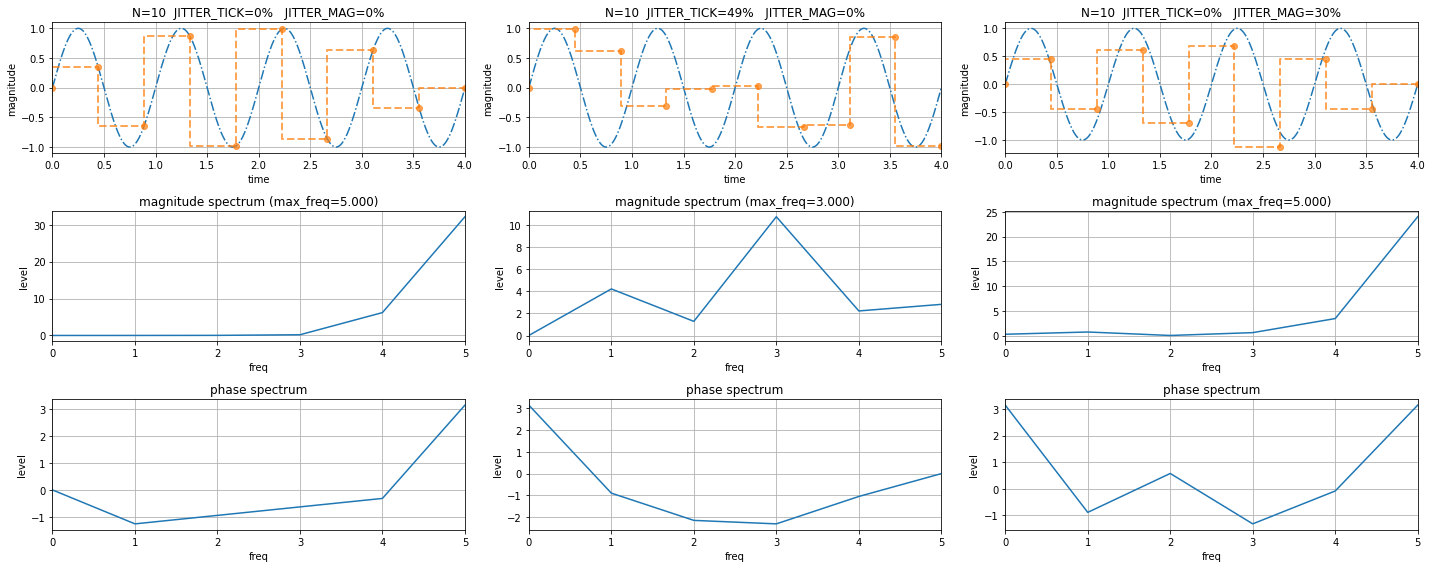

In [126]:
SIN_FREQ = 4

ideal_x, ideal_y = sin_tick(10000, SIN_FREQ)

N_FFT = 2048

for i, (sampling_rate, jit_tick, jit_amp) in enumerate((
    (10000, 49, 30),
    (5000, 49, 30),
    (500, 49, 30),
    (100, 49, 30),
    (25, 49, 30),
    (10, 49, 30),
)):
    fig = plt.figure(figsize=(20, 8))
    variants = (
        (0, 0),
        (jit_tick, 0),
        (0, jit_amp),
#         (jit_tick, jit_amp),
    )
    print(f'\n\nsampling_rate={sampling_rate}')
    for i, (jit_tick, jit_amp) in enumerate(variants):
        plt.subplot(3, len(variants), i + 1)
        plt.plot(ideal_x, ideal_y, '-.')
        plt.xlim((ideal_x[0], ideal_x[-1]))
        plt.grid()
        plt.title(f'N={sampling_rate}  JITTER_TICK={jit_tick}%   JITTER_MAG={jit_amp}%')

        x, y = sin_tick_rand_jitter(sampling_rate, SIN_FREQ, jit_tick, jit_amp)
        plt.step(x, y, '--o', linewidth=2.0, alpha=0.7)
        plt.xlabel("time")
        plt.ylabel("magnitude")

        plt.subplot(3, len(variants), i + 1 + len(variants))
        spectrum_magnitude(y, sampling_rate, plot=True)

        # phase
        plt.subplot(3, len(variants), i + 1 + 2 * len(variants))
        spectrum_phase(y, sampling_rate, plot=True)

    plt.tight_layout()
    plt.show()


# Convolution

In [127]:
T = TypeVar('T')

def convolution(s1: List[T], s2: List[T]) -> List[T]:
    s1, s2 = (s1, s2) if len(s1) > len(s2) else (s2, s1)
    z = [0] * (len(s2) - 1)
    ps = z + list(s1) + z
    s2_i = list(range(len(s2)))
    return [sum(ps[i+j] * s2[-j-1] for j in s2_i) for i in range(len(s1) + len(z))]

In [128]:
a = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
b = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 18, 20]

[]

[]

In [129]:
%%timeit
c = convolution(a, b)

56.9 µs ± 60.2 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [130]:
np.array(convolution(a, b))

array([  1,   4,  10,  20,  35,  56,  84, 120, 165, 220, 275, 330, 385,
       440, 495, 550, 605, 660, 714, 768, 801, 812, 800, 764, 703, 616,
       502, 360, 200])

# Spectrum

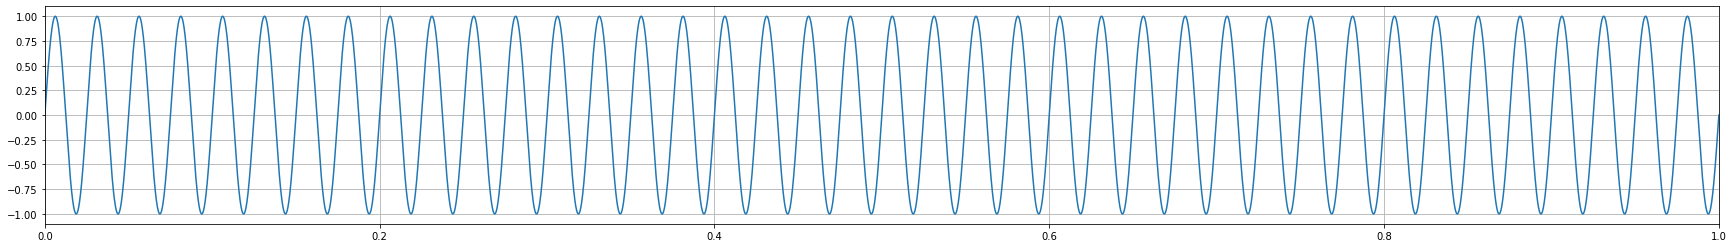

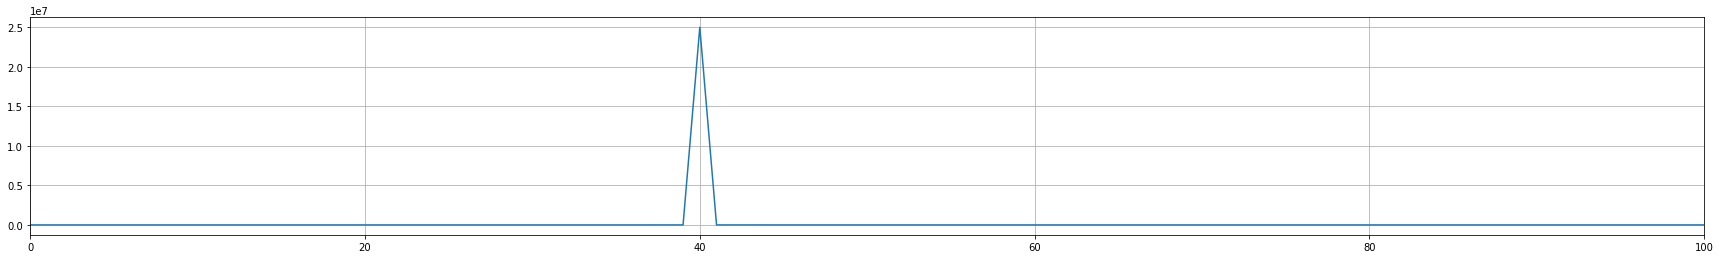

In [131]:
sampling_rate = 10000
t = np.linspace(0, 1, sampling_rate)

carrier_freq = 40

carrier_signal = np.sin(2*np.pi*carrier_freq*t)

signal_fft = np.fft.rfft(carrier_signal, sampling_rate)
spectrum = np.square(np.abs(signal_fft))

freq = np.linspace(0, sampling_rate/2, len(signal_fft))

plt.figure(figsize=(30, 4))
plt.grid()
plt.xlim((0, 1))
plt.plot(t, carrier_signal)
plt.show()

plt.figure(figsize=(30, 4))
plt.plot(freq, spectrum)
plt.xlim((0, 100))
plt.grid()
plt.show()


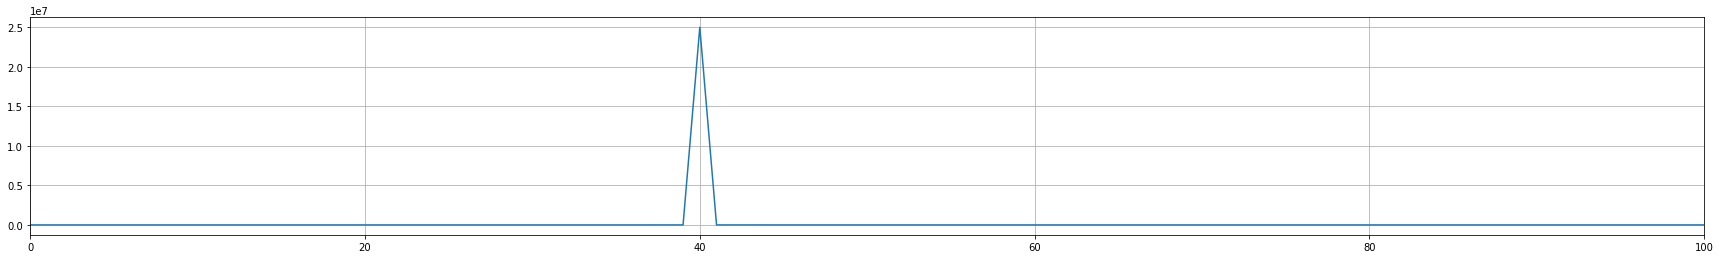

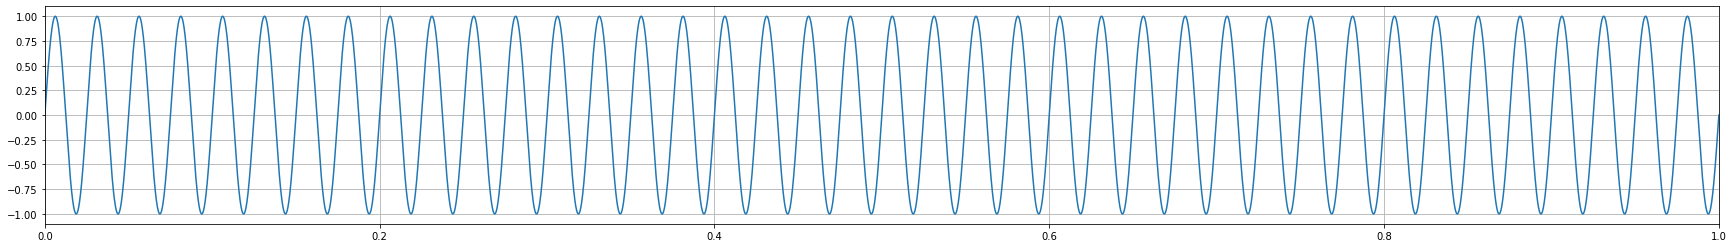

In [132]:
plt.figure(figsize=(30, 4))
plt.grid()
plt.plot(np.linspace(0, sampling_rate/2, len(signal_fft)), np.square(np.abs(signal_fft)))
plt.xlim((0, 100))
plt.show()

mk_signal_by_spectrum_magnitude(signal_fft, sampling_rate)

# AM

In [133]:
def sig_sin(t, freq, amp=1.0):
    return np.sin(2.*np.pi*freq*t)

def sig_bin(t, data: int, size = None, *, amp1: float = 1.0, amp0: float = -1.0):
    data = bin(data)[2:]
    if size is None:
        size = len(data) if len(data) % 8 == 0 else ((len(data) // 8 + 1) * 8)
    assert len(data) <= size
    data = ('0' * (size - len(data))) + data
    step = int(math.ceil(len(t) / size))
    i = 0
    res = []
    for ti in range(len(t)):
        if ti != 0 and ti % step == 0:
            i += 1
        res.append(amp1 if int(data[i]) else amp0)
        
    return np.array(res)

def sig_plot(t, signal, lim_f = None, horizontal = False):
    signal_fft = np.fft.rfft(signal, len(t))
    freq = np.linspace(0, len(t)/2, len(signal_fft))
    
    if horizontal:
        plt.figure(figsize=(30, 4))
        plt.subplot(1, 2, 1)
    else:
        plt.figure(figsize=(30, 8))
        plt.subplot(2, 1, 1)

    plt.grid()
    plt.xlim((0, 1))
    plt.plot(t, signal)

    if horizontal:
        plt.subplot(1, 2, 2)
    else:
        plt.subplot(2, 1, 2)
    
    spectrum = np.square(np.abs(signal_fft))
    plt.xlim((0, lim_f or freq[-1]))
    plt.ylim((0, np.max(spectrum) if np.max(spectrum) != 0. else 1))
    plt.grid()
    plt.plot(freq, spectrum)
    
    plt.show()

def sig_am(carrier_signal, message_signal, mu: int = 1):
    return (1+mu * message_signal)*carrier_signal

def sig_fm(t, carrier_freq, message_signal):
    return np.sin(2. * np.pi * (t * carrier_freq + message_signal))

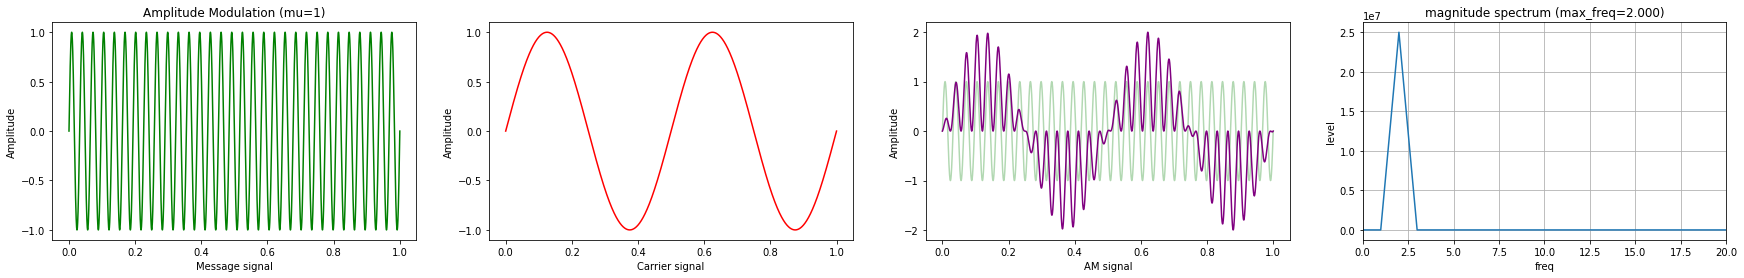

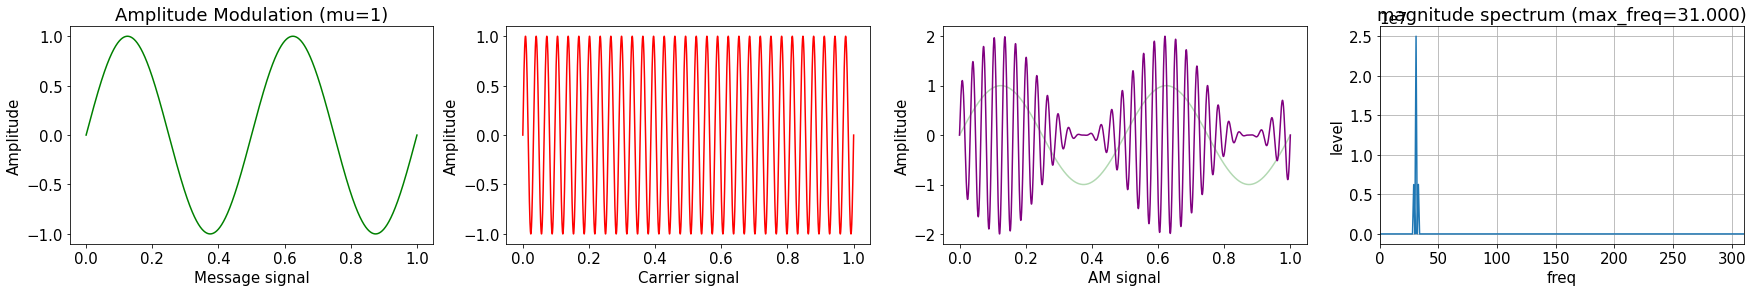

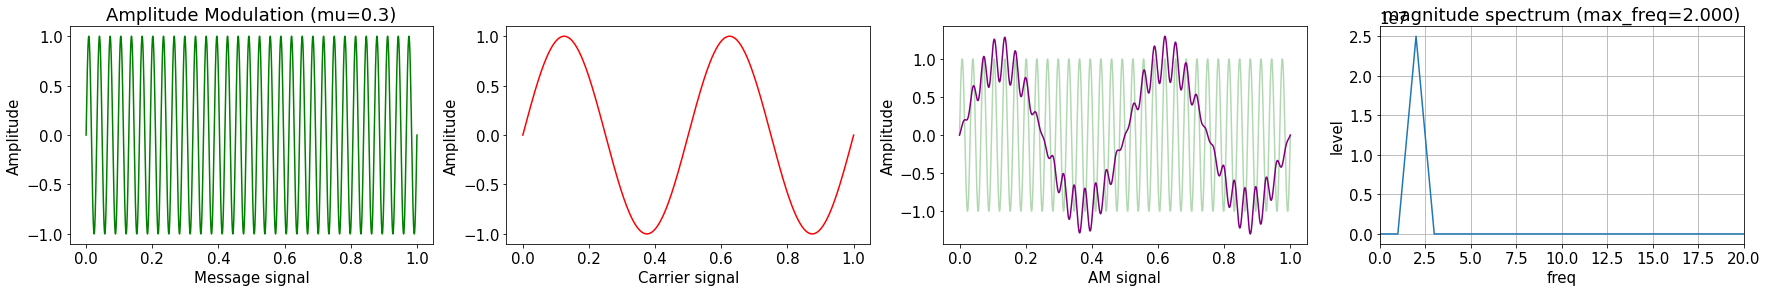

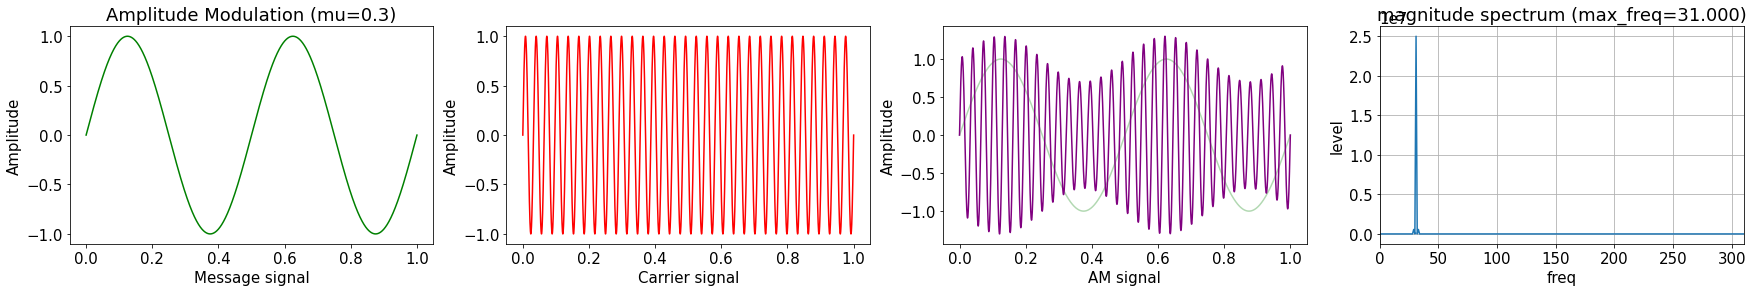

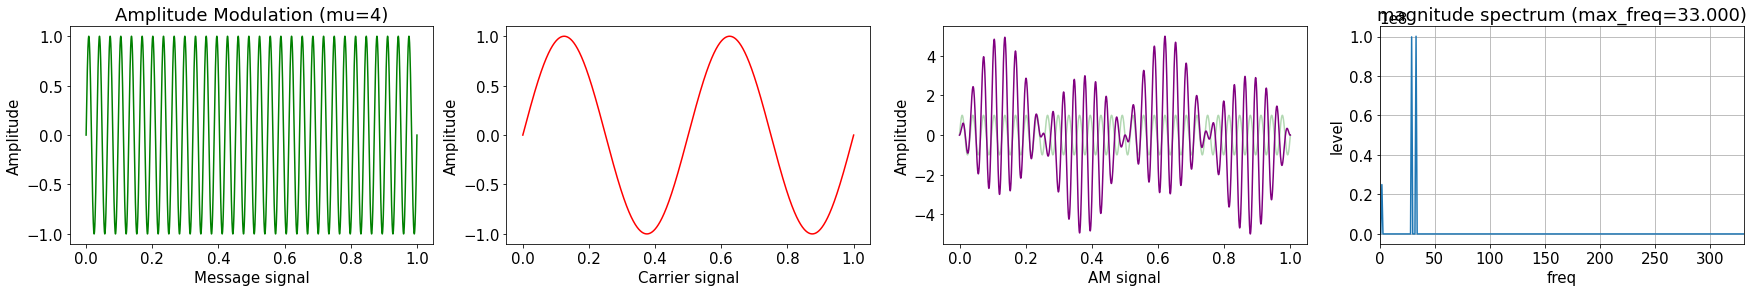

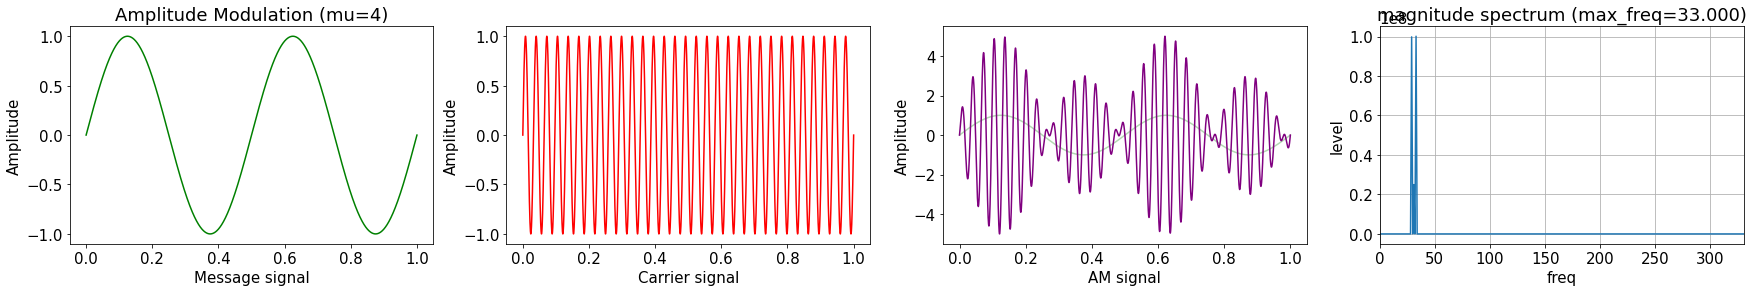

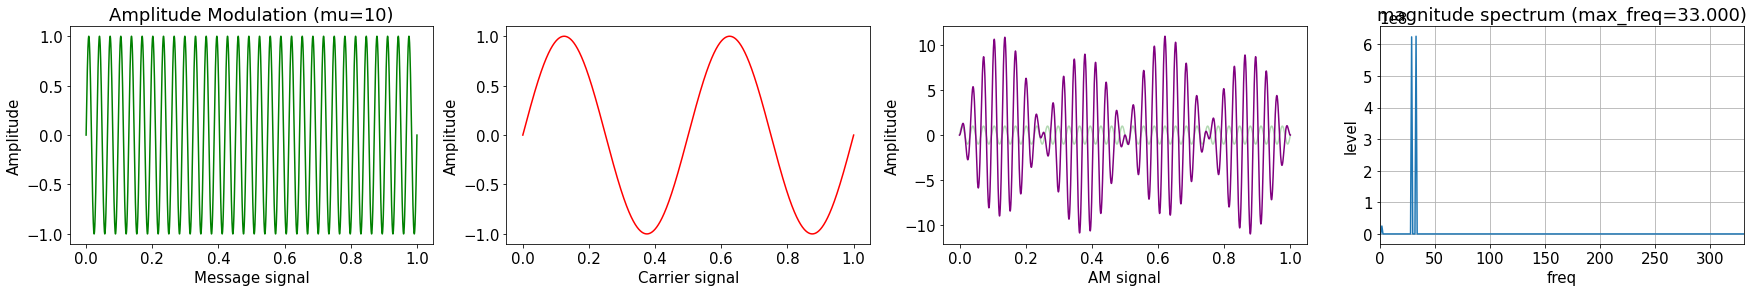

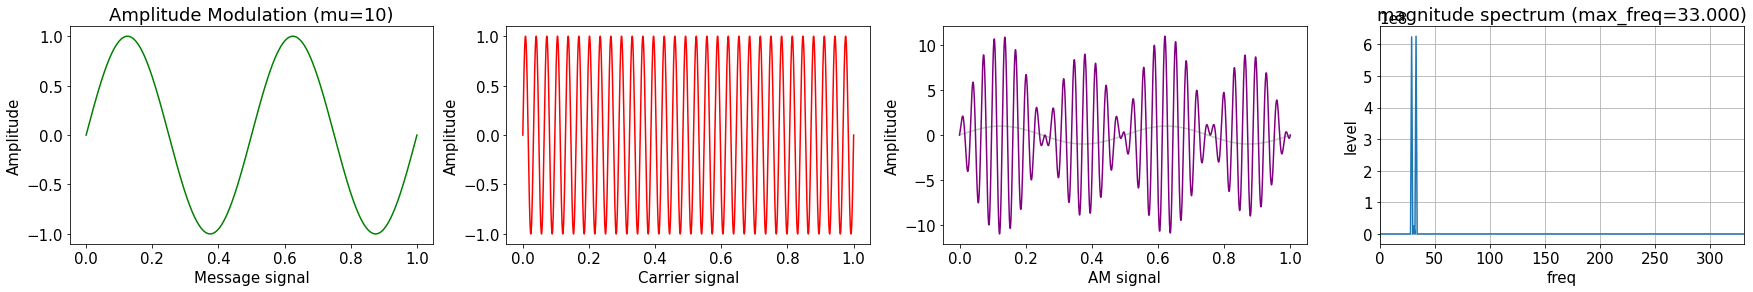

In [134]:
t = np.linspace(0, 1, 10000)
for f_c, f_m, mu in (
    (2, 31, 1),
    (31, 2, 1),
    (2, 31, 0.3),
    (31, 2, 0.3),
    (2, 31, 4),
    (31, 2, 4),
    (2, 31, 10),
    (31, 2, 10),
):
    fig = plt.figure(figsize=(30, 4))

    carrier = sig_sin(t, f_c)
    modulator = sig_sin(t, f_m)
    product = sig_am(carrier, modulator, mu)

    plt.subplot(1,4,1)
    plt.title(f'Amplitude Modulation (mu={mu})')
    plt.plot(t, modulator,'g')
    plt.ylabel('Amplitude')
    plt.xlabel('Message signal')

    plt.subplot(1,4,2)
    plt.plot(t, carrier, 'r')
    plt.ylabel('Amplitude')
    plt.xlabel('Carrier signal')

    plt.subplot(1,4,3)
    plt.plot(t, modulator,'g', alpha=0.3)
    plt.plot(t, product, color="purple")
    plt.ylabel('Amplitude')
    plt.xlabel('AM signal')

    plt.subplot(1, 4, 4)
    spectrum_magnitude(product, len(t), plot=True)

    plt.subplots_adjust(hspace=1)
    plt.rc('font', size=15)
    fig = plt.gcf()
    plt.show()


# AM Spectr|

5
message:


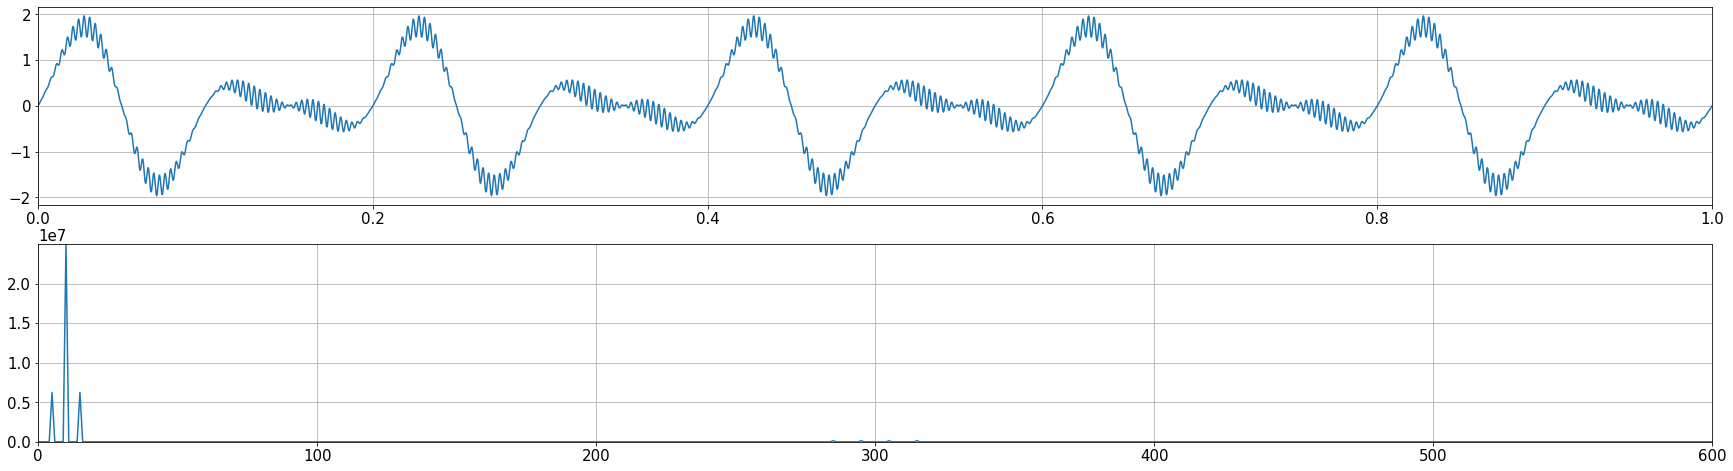

carrier (100):


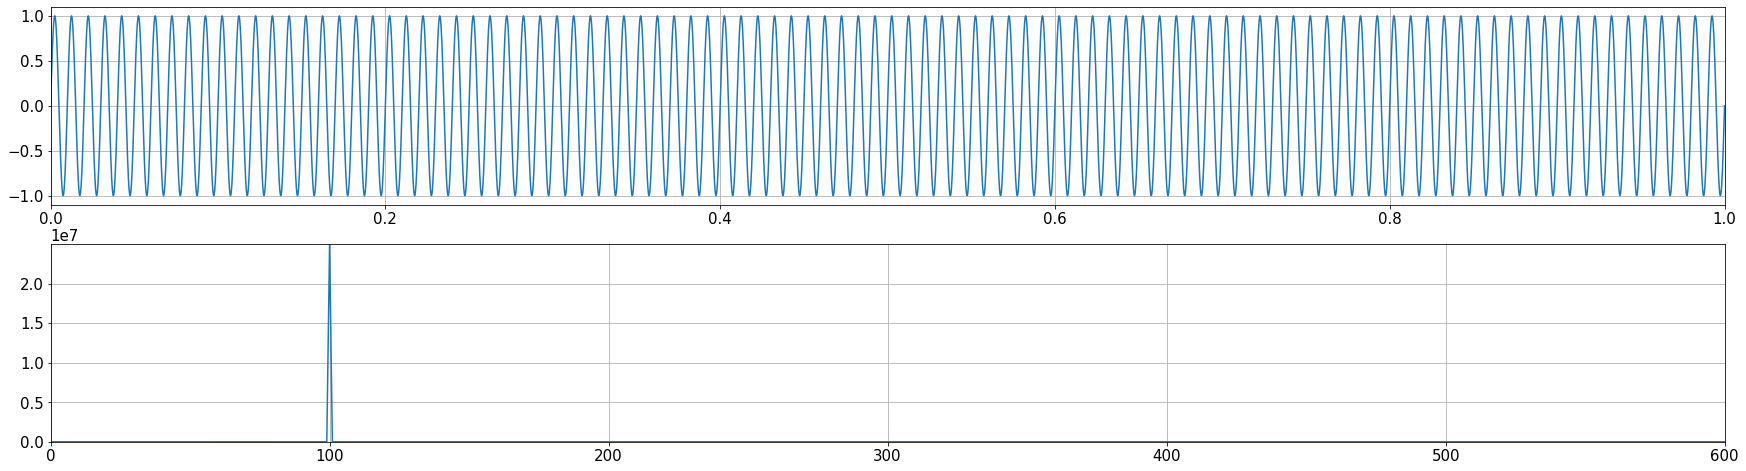

am_signal:


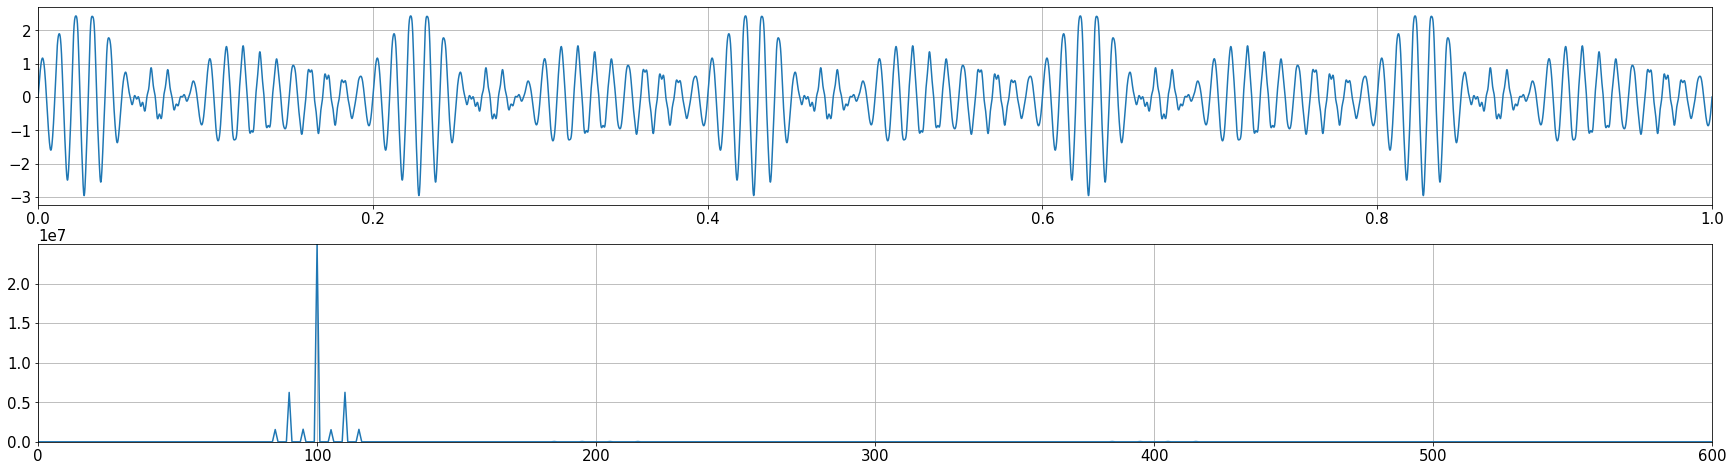

div = am_signal / carrier - 1


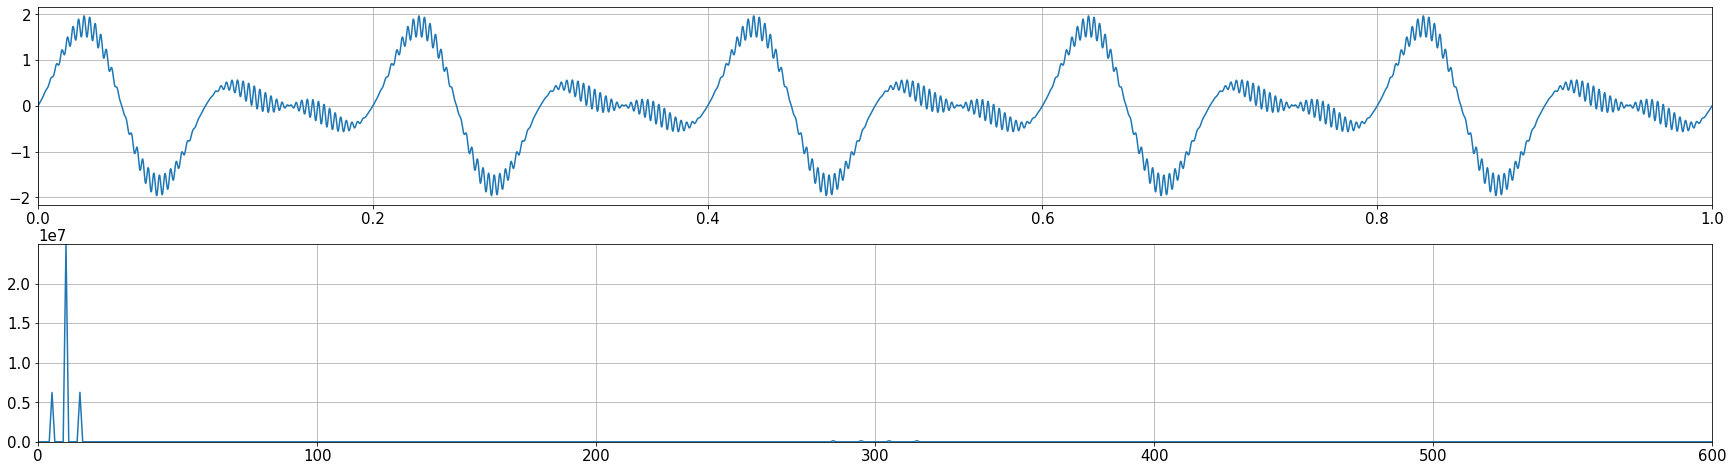

mul = am_signal * carrier


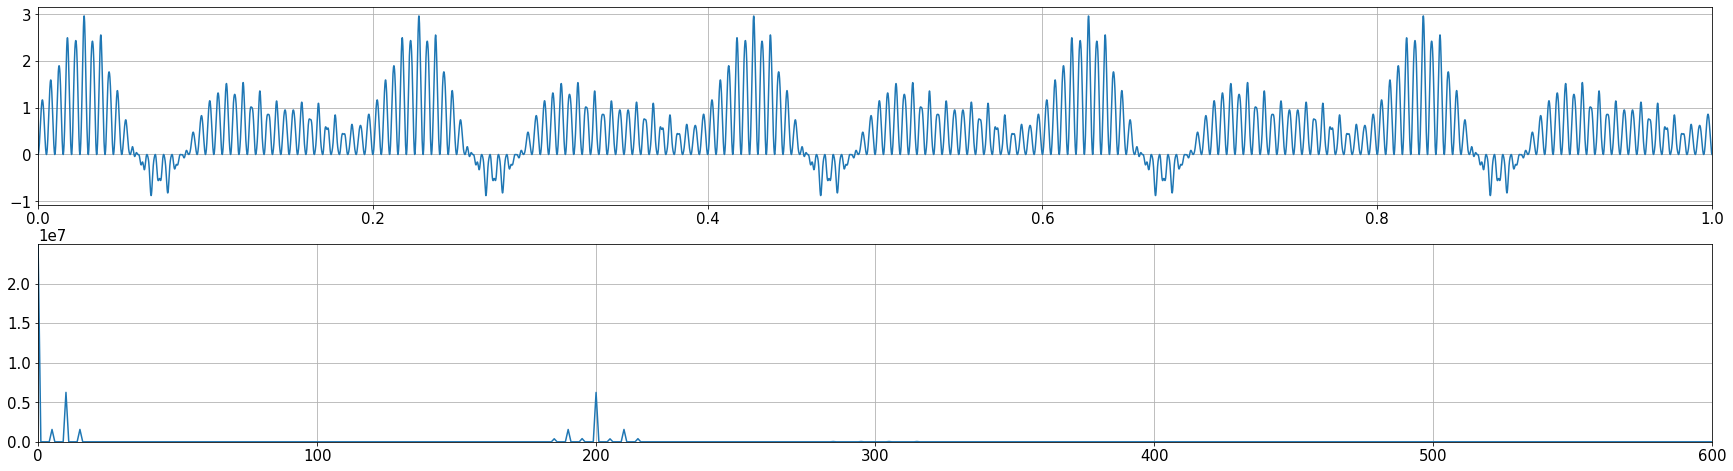

fft_filtered_mul(freq>100=0)


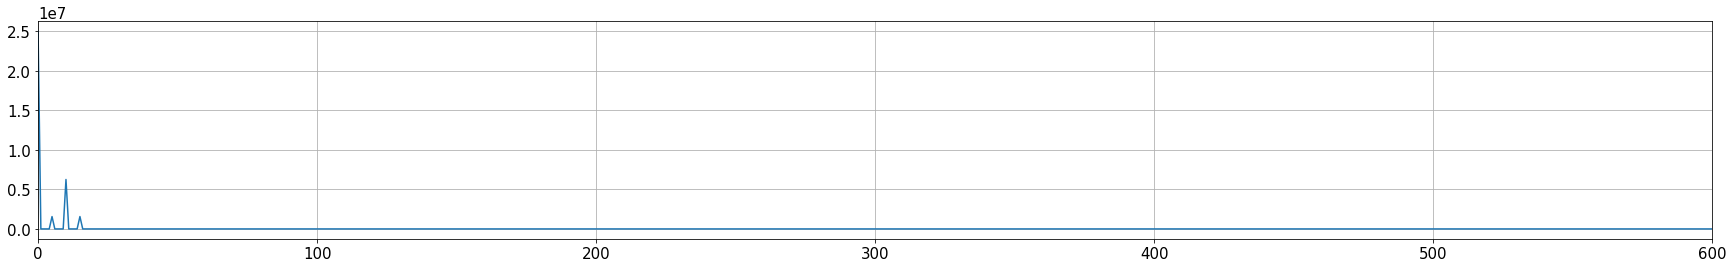

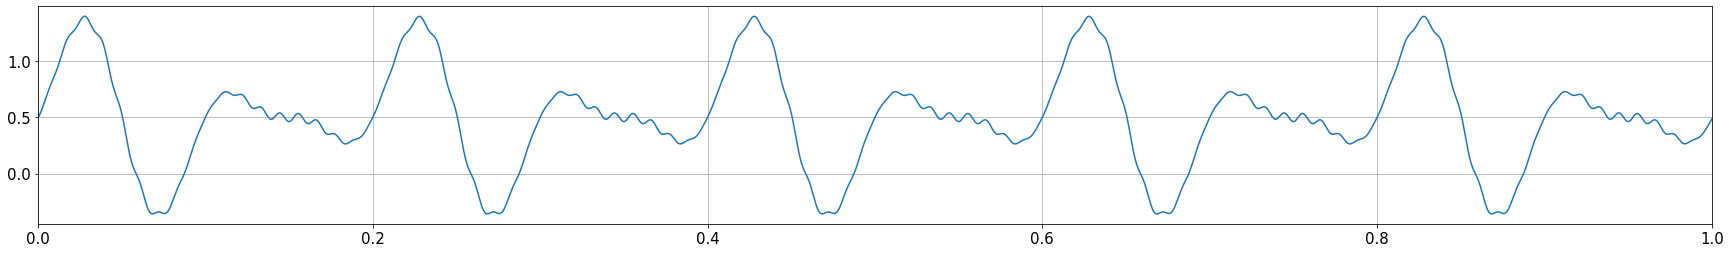

fft_filtered(freq>97 = 0)


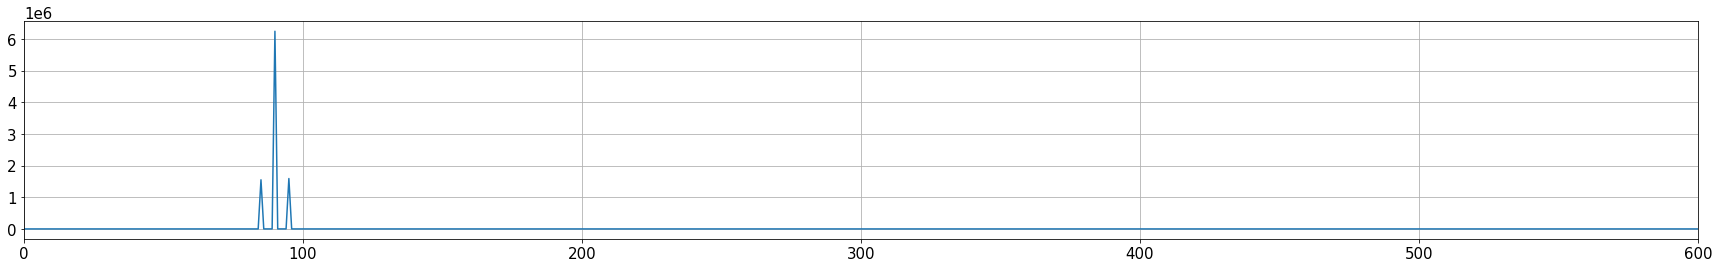

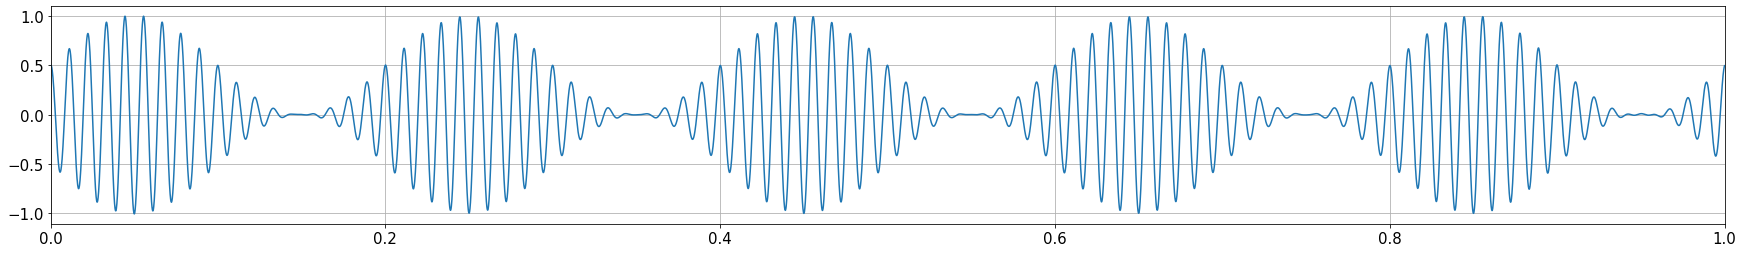

fft_sub = am_signal_fft - carrier_fft


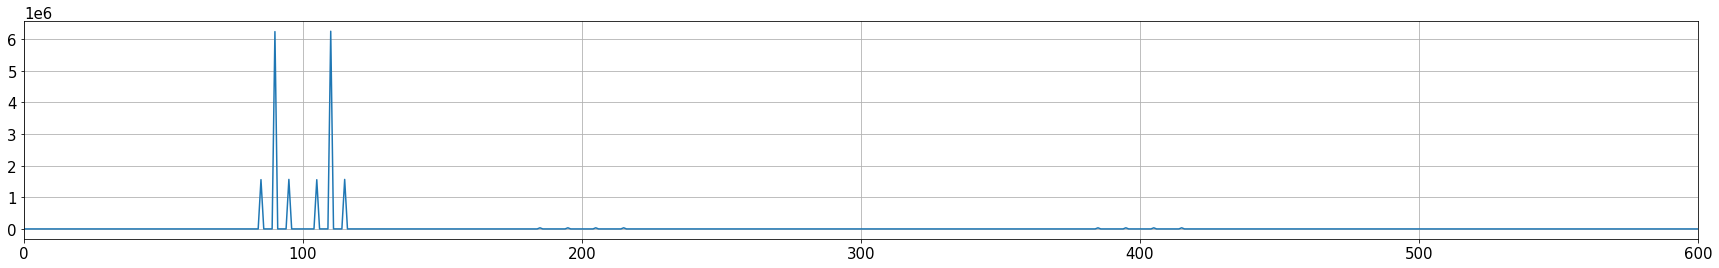

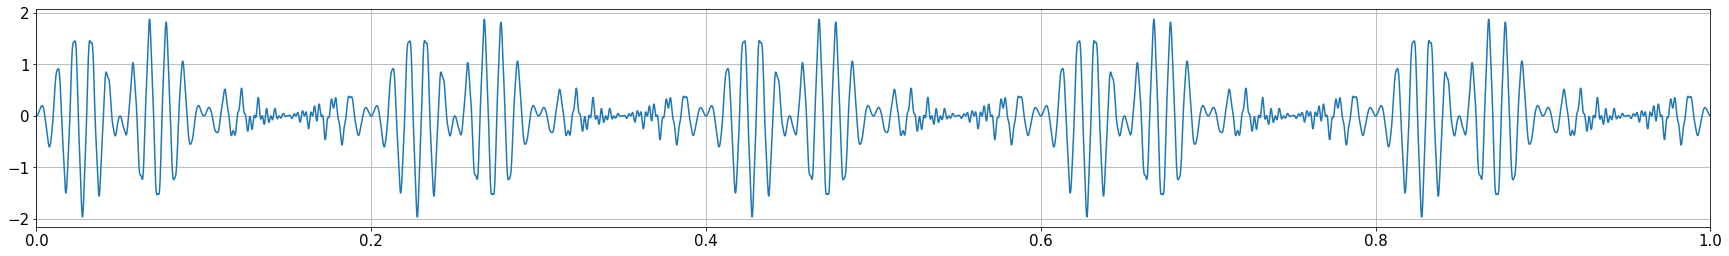

In [135]:
random.seed(123)

sampling_rate = 10000
t = np.linspace(0, 1, sampling_rate)

jit_f = 300
carrier_freq = 100
message_freq = int(100 * random.random())  # unknown
LIMIT_F = max(message_freq, carrier_freq, jit_f) * 2
print(message_freq)

carrier_signal = sig_sin(t, carrier_freq)
message_signal = sig_am(
    sig_sin(t, message_freq * 2), 
    sig_am(
        sig_sin(t, message_freq), 
        0.3 * sig_sin(t, jit_f)
    )
)
am_signal = sig_am(carrier_signal, message_signal)

message_signal_fft = np.fft.rfft(message_signal, sampling_rate)
carrier_signal_fft = np.fft.rfft(carrier_signal, sampling_rate)
am_signal_fft = np.fft.rfft(am_signal, sampling_rate)

freq = np.linspace(0, sampling_rate/2, len(am_signal_fft))

print('message:')
sig_plot(t, message_signal, LIMIT_F)

print(f'carrier ({carrier_freq}):')
sig_plot(t, carrier_signal, LIMIT_F)

print('am_signal:')
sig_plot(t, am_signal, LIMIT_F)

print('div = am_signal / carrier - 1')
sig_plot(t, np.divide(am_signal, carrier_signal, out=np.zeros_like(am_signal), where=carrier_signal!=0) - 1, LIMIT_F)

print('mul = am_signal * carrier')
sig_plot(t, am_signal * carrier_signal, LIMIT_F)

print(f'fft_filtered_mul(freq>{carrier_freq}=0)')
r_message_signal_fft = np.fft.rfft(am_signal * carrier_signal, sampling_rate) * (freq < (carrier_freq)).astype(float)
plt.figure(figsize=(30, 4))
plt.grid()
plt.plot(np.linspace(0, sampling_rate/2, len(r_message_signal_fft)), np.square(np.abs(r_message_signal_fft)))
plt.xlim((0, LIMIT_F))
plt.show()

mk_signal_by_spectrum_magnitude(r_message_signal_fft, sampling_rate)


FFT_FILTER_TRASHOLD = 3
print(f'fft_filtered(freq>{carrier_freq - FFT_FILTER_TRASHOLD} = 0)')
r_message_signal_fft = am_signal_fft * (freq <= (carrier_freq - FFT_FILTER_TRASHOLD)).astype(float)
plt.figure(figsize=(30, 4))
plt.grid()
plt.plot(np.linspace(0, sampling_rate/2, len(r_message_signal_fft)), np.square(np.abs(r_message_signal_fft)))
plt.xlim((0, LIMIT_F))
plt.show()

mk_signal_by_spectrum_magnitude(r_message_signal_fft, sampling_rate)


print('fft_sub = am_signal_fft - carrier_fft')
r_message_signal_fft = am_signal_fft - carrier_signal_fft

plt.figure(figsize=(30, 4))
plt.grid()
plt.plot(np.linspace(0, sampling_rate/2, len(r_message_signal_fft)), np.square(np.abs(r_message_signal_fft)))
plt.xlim((0, LIMIT_F))
plt.show()

mk_signal_by_spectrum_magnitude(r_message_signal_fft, sampling_rate)

# Correlation

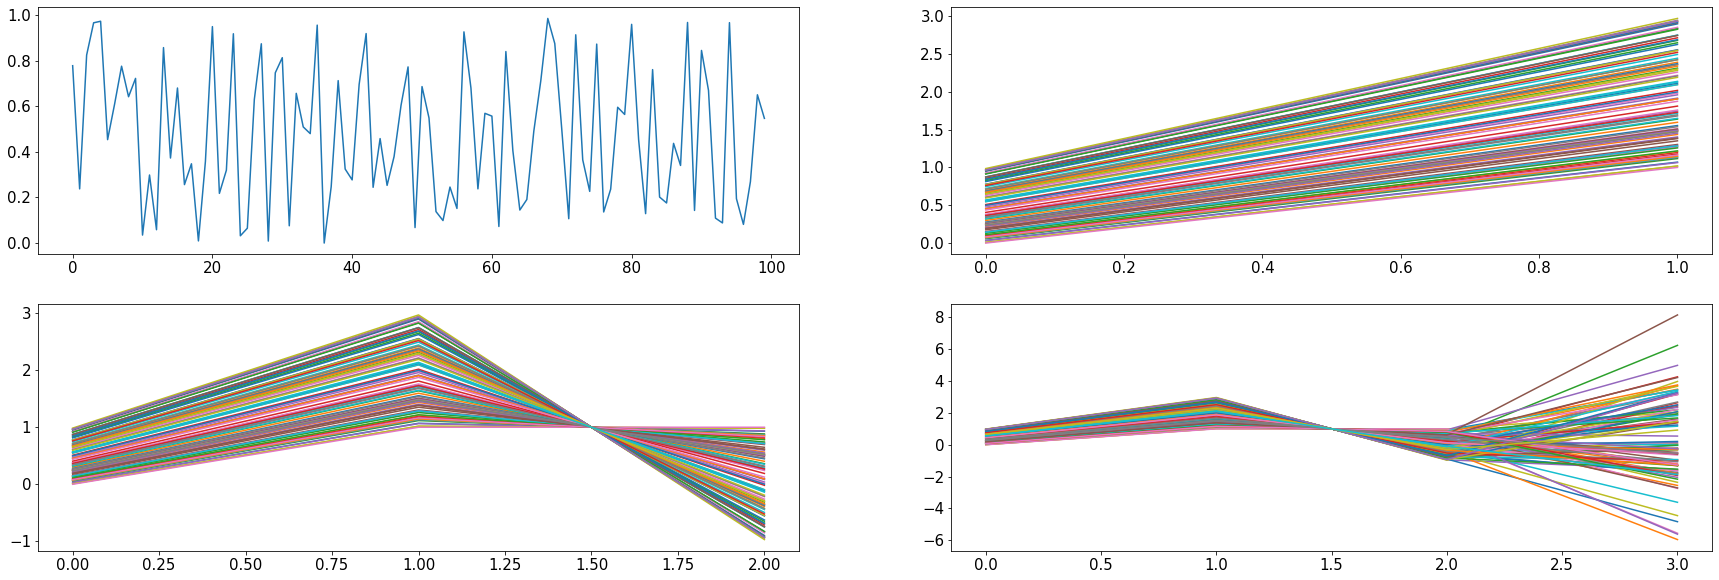

In [136]:
seed = 13
rand = np.random.RandomState(seed)

plt.figure(figsize=(30, 10))
x = rand.uniform(0,1,100)
plt.subplot(2, 2, 1)
plt.plot(x)

x = np.vstack((x,x*2+1))
plt.subplot(2, 2, 2)
plt.plot(x)

x = np.vstack((x,-x[0,]*2+1))
plt.subplot(2, 2, 3)
plt.plot(x)

x = np.vstack((x,rand.normal(1,3,100)))
plt.subplot(2, 2, 4)
plt.plot(x)
plt.show()

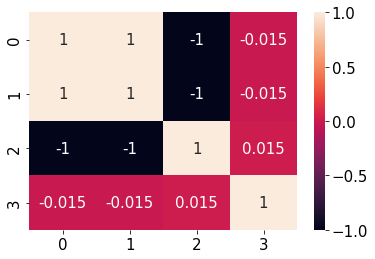

In [137]:
rho = np.corrcoef(x)

sn.heatmap(rho, annot=True);

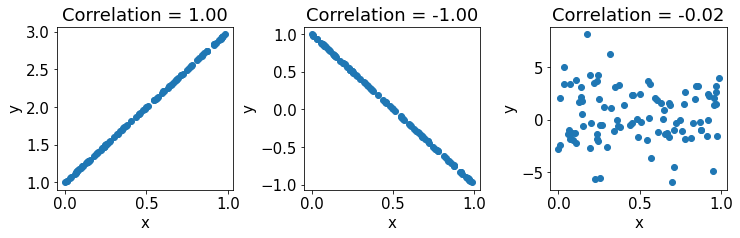

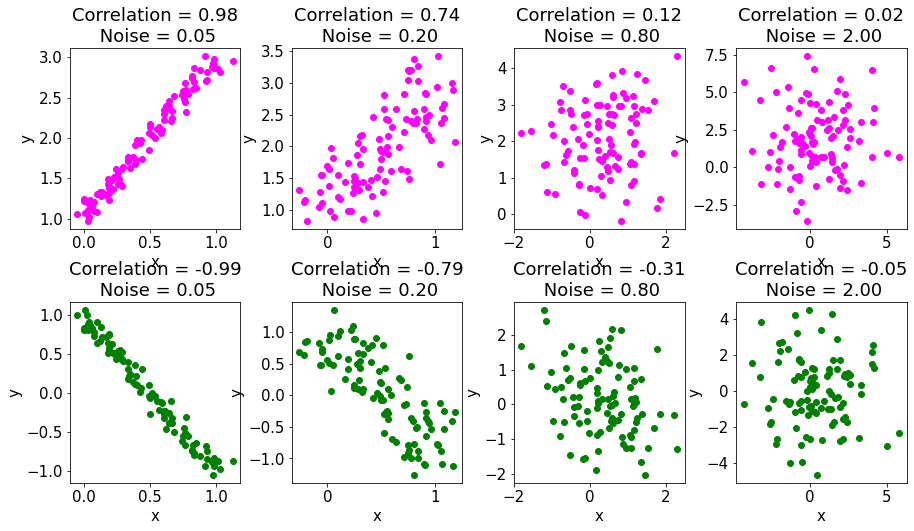

In [138]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))
for i in [0,1,2]:
    ax[i].scatter(x[0,],x[1+i,])
    ax[i].title.set_text('Correlation = ' + "{:.2f}".format(rho[0,i+1]))
    ax[i].set(xlabel='x',ylabel='y')
fig.subplots_adjust(wspace=.4)    
plt.show()



fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))

for noise, i in zip([0.05,0.2,0.8,2],[0,1,2,3]):
    # Add noise
    x_with_noise = x+rand.normal(0,noise,x.shape)
    
    # Compute correlation
    rho_noise = np.corrcoef(x_with_noise)
    
    # Plot column wise. Positive correlation in row 0 and negative in row 1
    ax[0,i].scatter(x_with_noise[0,],x_with_noise[1,],color='magenta')
    ax[1,i].scatter(x_with_noise[0,],x_with_noise[2,],color='green')
    ax[0,i].title.set_text('Correlation = ' + "{:.2f}".format(rho_noise[0,1])
                        + '\n Noise = ' + "{:.2f}".format(noise) )
    ax[1,i].title.set_text('Correlation = ' + "{:.2f}".format(rho_noise[0,2])
                        + '\n Noise = ' + "{:.2f}".format(noise))
    ax[0,i].set(xlabel='x',ylabel='y')    
    ax[1,i].set(xlabel='x',ylabel='y')
    
fig.subplots_adjust(wspace=0.3,hspace=0.4)    
plt.show()


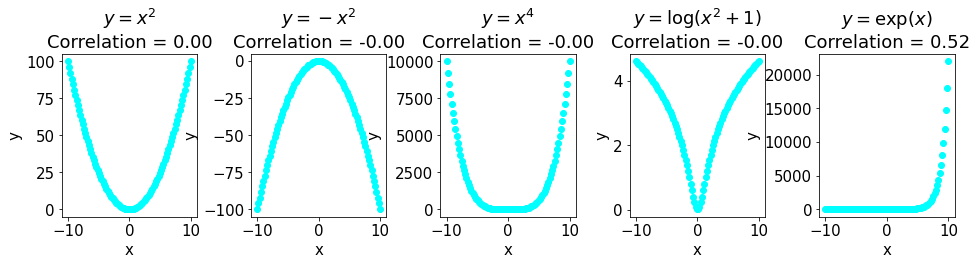

In [139]:
# Create a data matrix
x_nonlinear = np.linspace(-10,10,100)
x_nonlinear = np.vstack((x_nonlinear,x_nonlinear*x_nonlinear))
x_nonlinear = np.vstack((x_nonlinear,-x_nonlinear[0,]**2))
x_nonlinear = np.vstack((x_nonlinear,x_nonlinear[0,]**4))
x_nonlinear = np.vstack((x_nonlinear,np.log(x_nonlinear[0,]**2+1)))
x_nonlinear = np.vstack((x_nonlinear,np.exp(x_nonlinear[0,])))

# Compute the correlation
rho_nonlinear = np.corrcoef(x_nonlinear)

# Plot the data
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(16, 3))
title = ['$y=x^2$','$y=-x^2$','$y=x^4$','$y=\log(x^2+1)$','$y=\exp(x)$']
for i in [0,1,2,3,4]:
    ax[i].scatter(x_nonlinear[0,],x_nonlinear[1+i,],color='cyan')
    ax[i].title.set_text(title[i] + '\n' + 
                         'Correlation = ' + "{:.2f}".format(rho_nonlinear[0,i+1]))
    ax[i].set(xlabel='x',ylabel='y')
fig.subplots_adjust(wspace=.4)    
plt.show()


# Binary signal

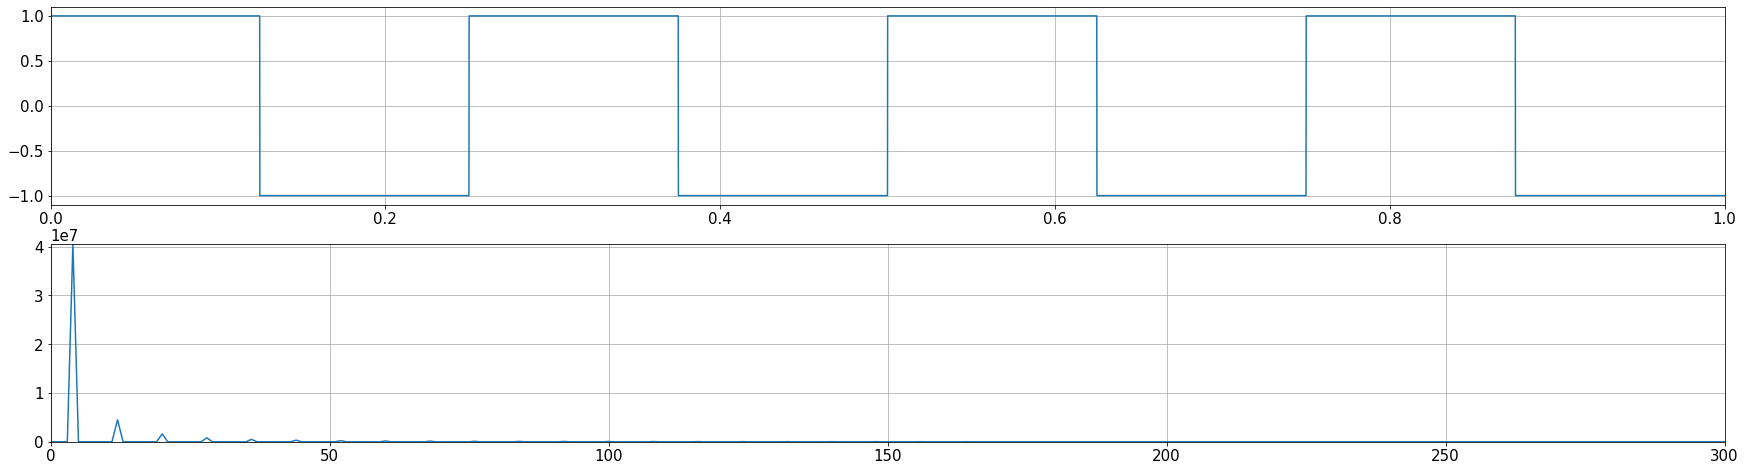

In [140]:
LIMIT_F = 300
t = np.linspace(0, 1, 10000)
dig_signal = sig_bin(t, int('0b10101010', 2))

sig_plot(t, dig_signal, LIMIT_F)

# FM


In [141]:
def sig_fm(t, carrier_freq, message_signal, mu = 1):
    res = [0.] * len(t)
    for i, ti in enumerate(t):
        res[i] = math.sin(2. * math.pi * ti * (carrier_freq + mu * message_signal[i]))
#         print(res[i])
    return np.array(res)
#     return np.sin(2. * np.pi * (t * carrier_freq + message_signal))

message signal


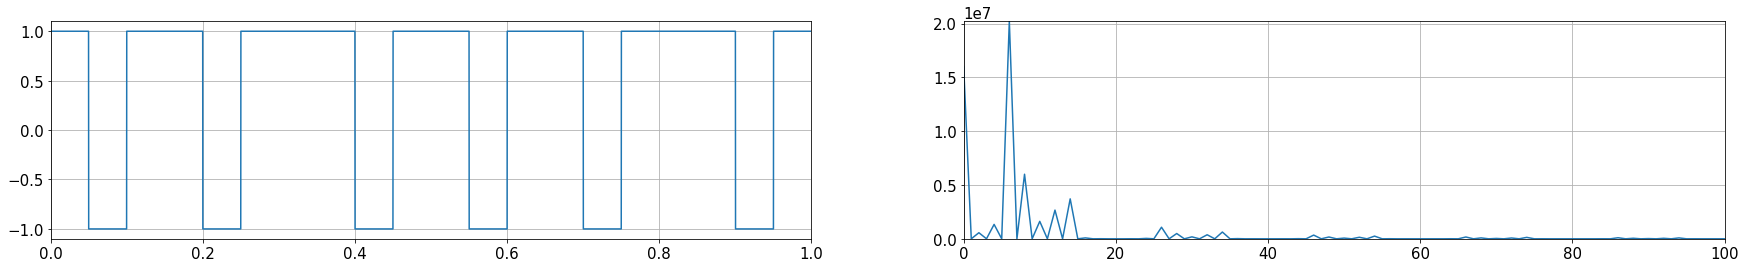

carrier signal


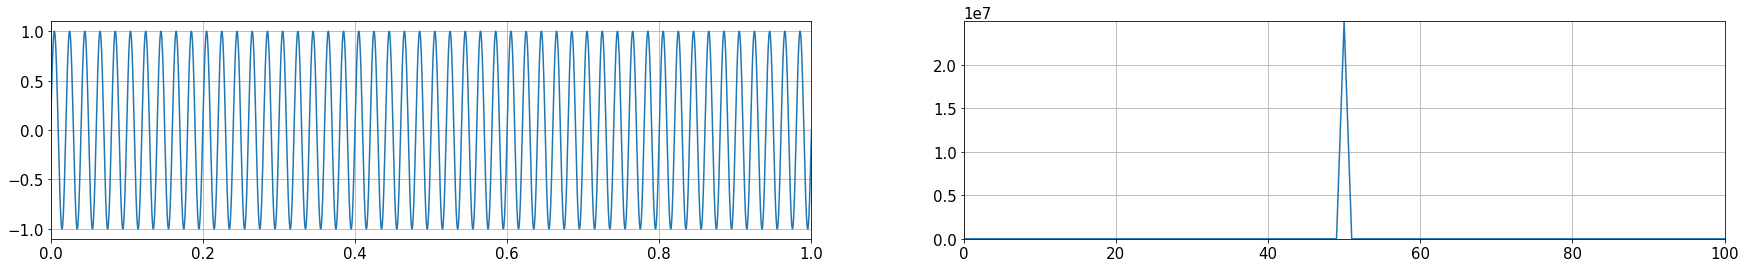

fm signal


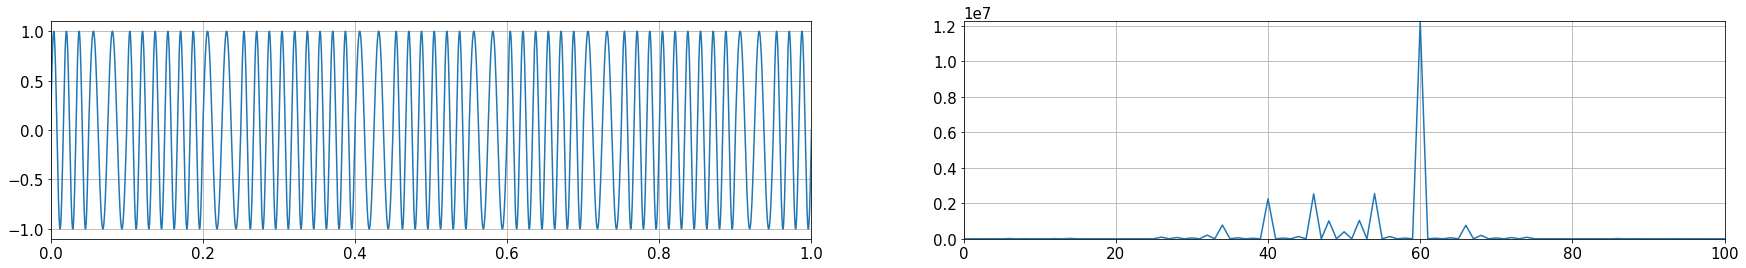

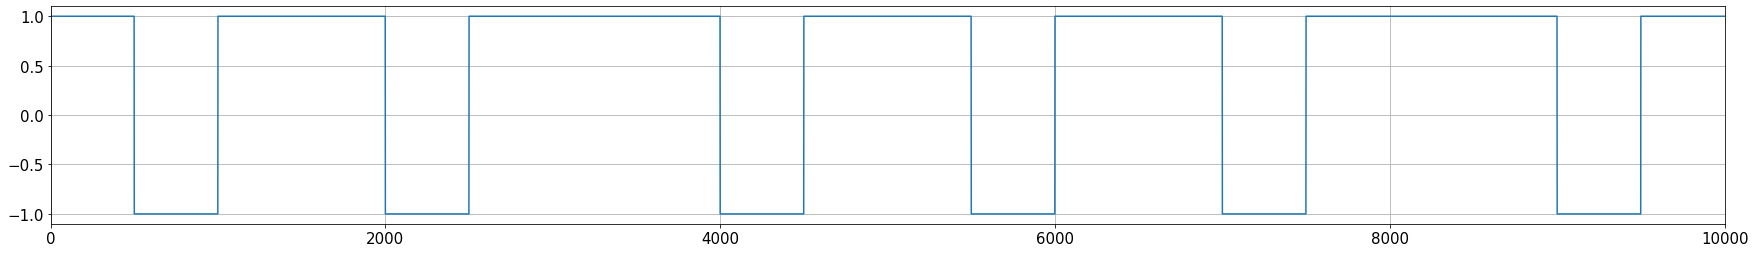

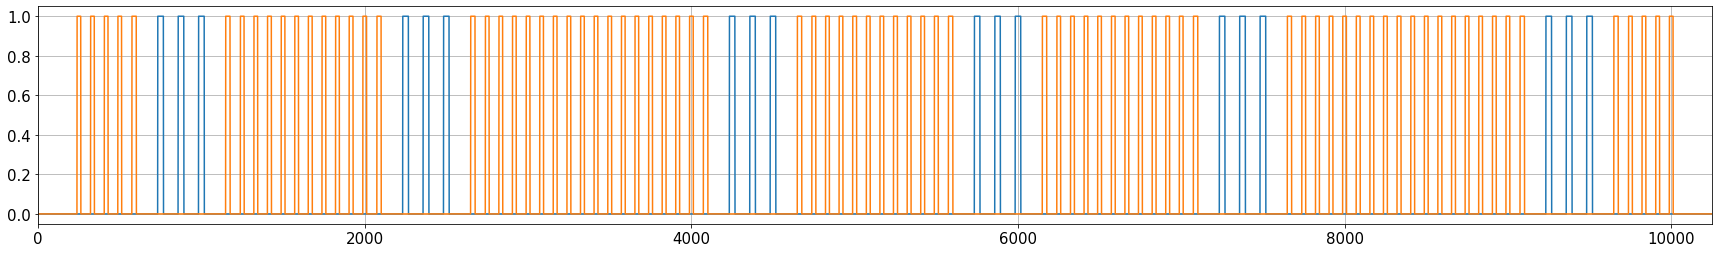

[1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1]


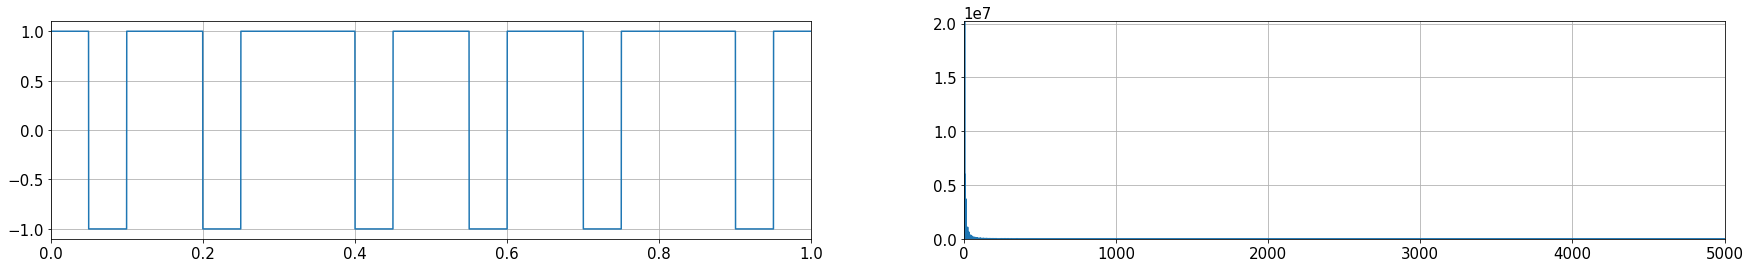

In [142]:
t = np.linspace(0, 1, 10000)
LIMIT_F = 100
carrier_freq = 50
size = 20
# message_signal = sig_sin(t, 10)
message_signal = sig_bin(t, int('0b10110111011011011101', 2), size=size, amp0=-1, amp1=1)

# print(message_signal)

# print(message_signal)

carrier_signal = sig_sin(t, carrier_freq)
fm_signal = sig_fm(t, carrier_freq, message_signal, mu=10)

print('message signal')
sig_plot(t, message_signal, LIMIT_F, horizontal=True)

print('carrier signal')
sig_plot(t, carrier_signal, LIMIT_F, horizontal=True)

print('fm signal')
sig_plot(t, fm_signal, LIMIT_F, horizontal=True)

zero_signal = sig_sin(t, 40)[:int(len(t)/2/size)]
one_signal = sig_sin(t, 60)[:int(len(t)/2/size)]

zero_conv = np.abs(np.convolve(fm_signal, zero_signal))
one_conv = np.abs(np.convolve(fm_signal, one_signal))
z_lvl = (max(np.max(zero_conv), np.max(one_conv)) * 0.9)
zero_conv = (zero_conv > z_lvl).astype(int)
one_conv = (one_conv > z_lvl).astype(int)
i_start = max(min(np.argmax(zero_conv==1), np.argmax(one_conv==1)) - 100, 0)
i_h = int(len(t)/size)
i_max = max(len(one_conv), len(zero_conv))
res = [0] * size
for j in range(size):
    i_j_start = i_start + j * i_h
    i_j_end = i_j_start + i_h - 1
    is_zero = np.sum(zero_conv[i_j_start:i_j_end]) > 10
    is_one = np.sum(one_conv[i_j_start:i_j_end]) > 10
    is_err = is_zero and is_one
    is_empty = (not is_zero) and (not is_one)
    if is_empty or is_err:
        res[j] = None
    elif is_one:
        res[j] = 1
    else:
        res[j] = 0

plt.figure(figsize=(30, 4))
plt.grid()
plt.xlim((0, len(message_signal)))
plt.plot(message_signal)
plt.show()

plt.figure(figsize=(30, 4))
plt.grid()
plt.xlim((0, len(zero_conv)))
plt.plot(zero_conv)
plt.plot(one_conv)
plt.show()
print(res)

sig_plot(t, sig_bin(t, int(''.join(str(r) for r in res), 2), size=size), horizontal=True)

In [143]:
def sine_wave(t, f,phase):
    return np.sin(2*np.pi*f*t+phase)

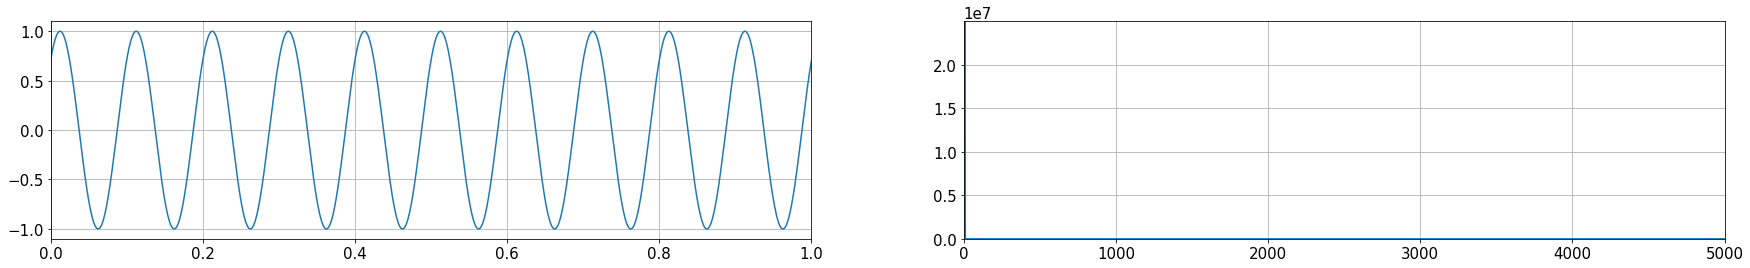

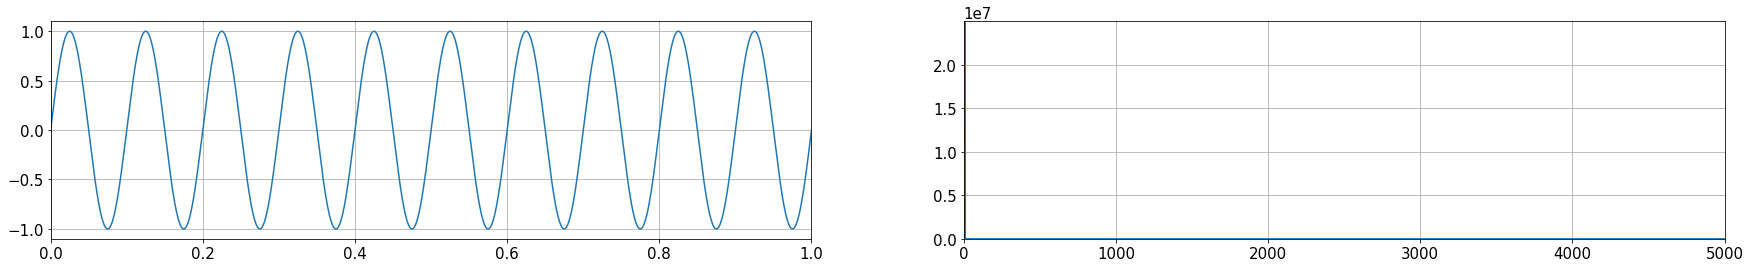

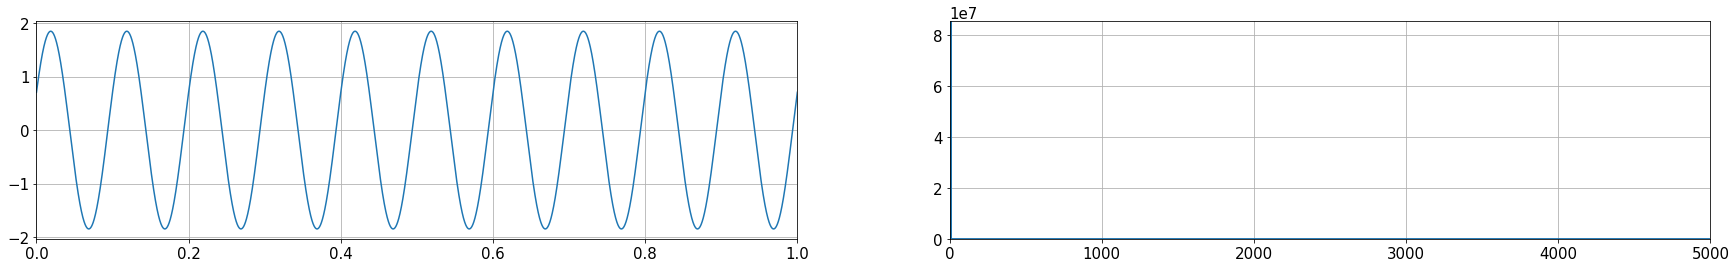

In [144]:
t = np.linspace(0, 1, 10000)
LIMIT_F = 300
s1 = sine_wave(t, 10, 1/4*np.pi)
s2 = sine_wave(t, 10, 0)
sig_plot(t, s1, horizontal=True)
sig_plot(t, s2, horizontal=True)
sig_plot(t, s1 + s2, horizontal=True)

# BPSK


In [145]:
def bpsk_mod(ak,L):
    """
    Function to modulate an incoming binary stream using BPSK (baseband)
    Parameters:
    ak : input binary data stream (0's and 1's) to modulate
    L : oversampling factor (Tb/Ts)
    Returns:
    (s_bb,t) : tuple of following variables
    s_bb: BPSK modulated signal(baseband) - s_bb(t)
    t : generated time base for the modulated signal
    """
    from scipy.signal import upfirdn
    s_bb = upfirdn(h=[1]*L, x=2*ak-1, up = L) # NRZ encoder
    t=np.arange(start = 0,stop = len(ak)*L) #discrete time base
    return (s_bb,t)

In [146]:
from numpy import sum,isrealobj,sqrt
from numpy.random import standard_normal

def awgn(s,SNRdB,L=1):
    """
    AWGN channel
    Add AWGN noise to input signal. The function adds AWGN noise vector to signal
    's' to generate a resulting signal vector 'r' of specified SNR in dB. It also
    returns the noise vector 'n' that is added to the signal 's' and the power
    spectral density N0 of noise added
    Parameters:
    s : input/transmitted signal vector
    SNRdB : desired signal to noise ratio (expressed in dB)
    for the received signal
    L : oversampling factor (applicable for waveform simulation)
    default L = 1.
    Returns:
    r : received signal vector (r=s+n)
    """
    gamma = 10**(SNRdB/10) #SNR to linear scale
    if s.ndim==1:# if s is single dimensional vector
        P=L*sum(abs(s)**2)/len(s) #Actual power in the vector
    else: # multi-dimensional signals like MFSK
        P=L*sum(sum(abs(s)**2))/len(s) # if s is a matrix [MxN]
    N0=P/gamma # Find the noise spectral density
    if isrealobj(s):# check if input is real/complex object type
        n = sqrt(N0/2)*standard_normal(s.shape) # computed noise
    else:
        n = sqrt(N0/2)*(standard_normal(s.shape)+1j*standard_normal(s.shape))
    r = s + n # received signal
    return r

NameError: name 'bpsk_demod' is not defined

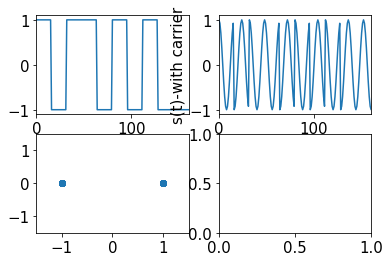

In [147]:
#Execute in Python3: exec(open("chapter_2/bpsk.py").read())
import numpy as np #for numerical computing
import matplotlib.pyplot as plt #for plotting functions
from scipy.special import erfc

N=100000 # Number of symbols to transmit
EbN0dB = np.arange(start=-4,stop = 11,step = 2) # Eb/N0 range in dB for simulation
L=16 # oversampling factor,L=Tb/Ts(Tb=bit period,Ts=sampling period)
# if a carrier is used, use L = Fs/Fc, where Fs >> 2xFc
Fc=800 # carrier frequency
Fs=L*Fc # sampling frequency
BER = np.zeros(len(EbN0dB)) # for BER values for each Eb/N0
ak = np.random.randint(2, size=N) # uniform random symbols from 0's and 1's
(s_bb,t)= bpsk_mod(ak,L) # BPSK modulation(waveform) - baseband
s = s_bb*np.cos(2*np.pi*Fc*t/Fs) # with carrier
# Waveforms at the transmitter
fig1, axs = plt.subplots(2, 2)
axs[0, 0].plot(t,s_bb) # baseband wfm zoomed to first 10 bits
axs[0, 0].set_xlabel('t(s)');axs[0, 1].set_ylabel(r'$s_{bb}(t)$-baseband')
axs[0, 1].plot(t,s) # transmitted wfm zoomed to first 10 bits
axs[0, 1].set_xlabel('t(s)');axs[0, 1].set_ylabel('s(t)-with carrier')
axs[0, 0].set_xlim(0,10*L);axs[0, 1].set_xlim(0,10*L)
#signal constellation at transmitter
axs[1, 0].plot(np.real(s_bb),np.imag(s_bb),'o')
axs[1, 0].set_xlim(-1.5,1.5);axs[1, 0].set_ylim(-1.5,1.5)
for i,EbN0 in enumerate(EbN0dB):
    # Compute and add AWGN noise
    r = awgn(s,EbN0,L) # refer Chapter section 4.1
    r_bb = r*np.cos(2*np.pi*Fc*t/Fs) # recovered baseband signal
    ak_hat = bpsk_demod(r_bb,L) # baseband correlation demodulator
    BER[i] = np.sum(ak !=ak_hat)/N # Bit Error Rate Computation
    # Received signal waveform zoomed to first 10 bits
    axs[1, 1].plot(t,r) # received signal (with noise)
    axs[1, 1].set_xlabel('t(s)');axs[1, 1].set_ylabel('r(t)')
    axs[1, 1].set_xlim(0,10*L)
#------Theoretical Bit/Symbol Error Rates-------------
theoreticalBER = 0.5*erfc(np.sqrt(10**(EbN0dB/10))) # Theoretical bit error rate
#-------------Plots---------------------------
fig2, ax1 = plt.subplots(nrows=1,ncols = 1)
ax1.semilogy(EbN0dB,BER,'k*',label='Simulated') # simulated BER
ax1.semilogy(EbN0dB,theoreticalBER,'r-',label='Theoretical')
ax1.set_xlabel(r'$E_b/N_0$ (dB)')
ax1.set_ylabel(r'Probability of Bit Error - $P_b$')
ax1.set_title(['Probability of Bit Error for BPSK modulation'])
ax1.legend();fig1.show();fig2.show()